In [107]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import pickle
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [108]:
def plot_roc(model, x_columns, y_true):

    y_pred = model.predict_proba(x_columns)

    fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
    area_under_curve = auc(fpr, tpr)

    # method I: plt
    fig, ax = plt.subplots()
    model_name = str(type(model)).split('.')[-1].strip(">\'")
    plt.title(f'{model_name} ROC')
    ax.plot(fpr, tpr, 'k', label = 'C AUC = %0.3f' % area_under_curve)

    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [127]:
def gb_best_features(df, x_cols, n_features, true_col='closed_on_google'):
    
    x_columns = df[x_cols].fillna(False)

    y_true = df[true_col]

    gb_model = GradientBoostingClassifier(n_estimators=100)
    
    gb_model.fit(x_columns, y_true)
    
    feature_importances = {}
    
    for i in range(len(gb_model.feature_importances_)):
        
        feature_importances[x_columns.columns[i]] = gb_model.feature_importances_[i]
    
    
    top_features = Counter(feature_importances).most_common(n_features)
    
    values = [feature[1] for feature in top_features]
    
    features = [feature[0] for feature in top_features]
    
    return values, features


def plot_best_features(values, features, figsize_x=10, figsize_y=10):
    
    new_df = pd.DataFrame(list(zip(values,features))).set_index(1).sort_values(0)

    new_df.plot.barh(figsize=(figsize_x,figsize_y))

In [109]:
def rf_best_features(df, x_cols, n_features, true_col='closed_on_google'):
    
    x_columns = df[x_cols]

    y_true = df[true_col]

    rf_model = RandomForestClassifier(n_estimators=100)
    
    rf_model.fit(x_columns, y_true)
    
    feature_importances = {}
    
    for i in range(len(rf_model.feature_importances_)):
        
        feature_importances[x_columns.columns[i]] = rf_model.feature_importances_[i]
    
    
    top_features = Counter(feature_importances).most_common(n_features)
    
    values = [feature[1] for feature in top_features]
    
    features = [feature[0] for feature in top_features]
    
    return values, features


def plot_best_features(values, features, figsize_x=10, figsize_y=10):
    
    new_df = pd.DataFrame(list(zip(values,features))).set_index(1).sort_values(0)

    new_df.plot.barh(figsize=(figsize_x,figsize_y))

In [110]:
df = pd.read_csv('../data/featurized_dataframe.csv')

In [111]:
df[x_columns][:40].fillna(False)

,restaurant_count,restaurant_count > 1,restaurant_count > 5,restaurant_count > 25,review_count,stars,Attribute|BusinessAcceptsCreditCards value:,Attribute|RestaurantsPriceRange2 value:,Attribute|RestaurantsTakeOut value:,Attribute|BusinessParking|garage value:,Attribute|BusinessParking|street value:,Attribute|BusinessParking|lot value:,Attribute|BusinessParking|valet value:,Attribute|BusinessParking|validated value:,Attribute|BikeParking value:,Attribute|OutdoorSeating value:,Attribute|RestaurantsGoodForGroups value:,Attribute|RestaurantsDelivery value:,Attribute|RestaurantsReservations value:,Attribute|GoodForKids value:,Attribute|HasTV value:,Attribute|Ambience|romantic value:,Attribute|Ambience|intimate value:,Attribute|Ambience|classy value:,Attribute|Ambience|hipster value:,Attribute|Ambience|touristy value:,Attribute|Ambience|trendy value:,Attribute|Ambience|upscale value:,Attribute|Ambience|casual value:,Attribute|Ambience|divey value:,Attribute|GoodForMeal|dessert value:,Attribute|GoodForMeal|latenight value:,Attribute|GoodForMeal|lunch value:,Attribute|GoodForMeal|dinner value:,Attribute|GoodForMeal|breakfast value:,Attribute|GoodForMeal|brunch value:,Attribute|Caters value:,Attribute|WheelchairAccessible value:,Attribute|HappyHour value:,Attribute|GoodForDancing value:,Attribute|DriveThru value:,Attribute|Music|dj value:,Attribute|Music|background_music value:,Attribute|Music|no_music value:,Attribute|Music|karaoke value:,Attribute|Music|live value:,Attribute|Music|video value:,Attribute|Music|jukebox value:,Attribute|CoatCheck value:,Attribute|DogsAllowed value:,Category|Restaurants_true,Category|Food_true,Category|Nightlife_true,Category|Bars_true,Category|Fast Food_true,Category|American (Traditional)_true,Category|Sandwiches_true,Category|Pizza_true,Category|Mexican_true,Category|Burgers_true,Category|American (New)_true,Category|Breakfast & Brunch_true,Category|Coffee & Tea_true,Category|Grocery_true,Category|Italian_true,Category|Specialty Food_true,Category|Shopping_true,Category|Chinese_true,Category|Event Planning & Services_true,Category|Chicken Wings_true,Category|Salad_true,Category|Bakeries_true,Category|Desserts_true,Category|Convenience Stores_true,Category|Ice Cream & Frozen Yogurt_true,Category|Sports Bars_true,Category|Seafood_true,Category|Beer_true,Category|Wine & Spirits_true,Category|Caterers_true,Category|Delis_true,Category|Cafes_true,Category|Drugstores_true,Category|Japanese_true,Category|Arts & Entertainment_true,Category|Juice Bars & Smoothies_true,Category|Pubs_true,Category|Steakhouses_true,Category|Sushi Bars_true,Category|Asian Fusion_true,Category|Barbeque_true,Category|Diners_true,Category|Lounges_true,Category|Automotive_true,Category|Gas Stations_true,Category|Cocktail Bars_true,Category|Mediterranean_true,Category|Wine Bars_true,Category|Food Trucks_true,Category|Tex-Mex_true,...,five-star: small,five-star: town,2-4_star: asked,five-star: fantastic,2-4_star: long,five-star: didn,five-star: breakfast,2-4_star: beer,five-star: beer,2-4_star: vegas,five-star: table,2-4_star: breakfast,five-star: burger,one_star: place,2-4_star: tea,five-star: place,one_star: food,one_star: just,2-4_star: place,five-star: tea,2-4_star: time,2-4_star: food,five-star: don,2-4_star: like,one_star: like,five-star: food,five-star: just,2-4_star: wasn,five-star: like,2-4_star: service,one_star: tea,one_star: business,one_star: said,one_star: ordered,one_star: tasted,one_star: time,one_star: service,2-4_star: good,2-4_star: don,one_star: going,one_star: didn,2-4_star: just,one_star: called,one_star: wasn,five-star: time,five-star: service,2-4_star: ordered,2-4_star: said,five-star: good,five-star: ordered,one_star: order,one_star: went,one_star: pizza,one_star: good,2-4_star: bad,five-star: got,five-star: going,one_star: owner,five-star: bar,five-star: restaurant,one_star: half,one_star: don,2-4_star: want,one_star: terrible,one_star: bar,one_star: really,one_star: minutes,five-star: amazing,2-4_star: really

In [112]:
yelp_columns = ['restaurant_count','restaurant_count > 1','restaurant_count > 5',
                'restaurant_count > 25','review_count','stars',
                'Attribute|BusinessAcceptsCreditCards value:',
 'Attribute|RestaurantsPriceRange2 value:','Attribute|RestaurantsTakeOut value:',
'Attribute|BusinessParking|garage value:','Attribute|BusinessParking|street value:',
'Attribute|BusinessParking|lot value:', 'Attribute|BusinessParking|valet value:',
'Attribute|BusinessParking|validated value:','Attribute|BikeParking value:','Attribute|OutdoorSeating value:',
 'Attribute|RestaurantsGoodForGroups value:','Attribute|RestaurantsDelivery value:','Attribute|RestaurantsReservations value:',
 'Attribute|GoodForKids value:','Attribute|HasTV value:','Attribute|Ambience|romantic value:',
 'Attribute|Ambience|intimate value:','Attribute|Ambience|classy value:','Attribute|Ambience|hipster value:',
 'Attribute|Ambience|touristy value:','Attribute|Ambience|trendy value:','Attribute|Ambience|upscale value:',
 'Attribute|Ambience|casual value:','Attribute|Ambience|divey value:',
 'Attribute|GoodForMeal|dessert value:','Attribute|GoodForMeal|latenight value:',
 'Attribute|GoodForMeal|lunch value:','Attribute|GoodForMeal|dinner value:','Attribute|GoodForMeal|breakfast value:',
 'Attribute|GoodForMeal|brunch value:','Attribute|Caters value:',
 'Attribute|WheelchairAccessible value:','Attribute|HappyHour value:',
 'Attribute|GoodForDancing value:','Attribute|DriveThru value:','Attribute|Music|dj value:',
'Attribute|Music|background_music value:','Attribute|Music|no_music value:','Attribute|Music|karaoke value:',
 'Attribute|Music|live value:','Attribute|Music|video value:','Attribute|Music|jukebox value:','Attribute|CoatCheck value:',
 'Attribute|DogsAllowed value:','Category|Restaurants_true','Category|Food_true',
 'Category|Nightlife_true','Category|Bars_true','Category|Fast Food_true','Category|American (Traditional)_true',
 'Category|Sandwiches_true','Category|Pizza_true','Category|Mexican_true','Category|Burgers_true',
 'Category|American (New)_true','Category|Breakfast & Brunch_true','Category|Coffee & Tea_true',
'Category|Grocery_true','Category|Italian_true','Category|Specialty Food_true','Category|Shopping_true',
 'Category|Chinese_true','Category|Event Planning & Services_true','Category|Chicken Wings_true',
'Category|Salad_true','Category|Bakeries_true','Category|Desserts_true','Category|Convenience Stores_true',
'Category|Ice Cream & Frozen Yogurt_true','Category|Sports Bars_true','Category|Seafood_true','Category|Beer_true',
'Category|Wine & Spirits_true','Category|Caterers_true','Category|Delis_true','Category|Cafes_true',
'Category|Drugstores_true','Category|Japanese_true','Category|Arts & Entertainment_true',
'Category|Juice Bars & Smoothies_true','Category|Pubs_true','Category|Steakhouses_true','Category|Sushi Bars_true',
'Category|Asian Fusion_true','Category|Barbeque_true','Category|Diners_true','Category|Lounges_true',
    'Category|Automotive_true','Category|Gas Stations_true','Category|Cocktail Bars_true',
'Category|Mediterranean_true','Category|Wine Bars_true','Category|Food Trucks_true','Category|Tex-Mex_true']

census_columns = ['2016 ACS 5-Year Population Estimate',
                 'American Indian and Alaska Native alone',
                 'Asian alone',
                 'Black or African American alone',
                 'Census 2010 Total Population',
                 'Educational Attainment: Percent high school graduate or higher',
                 'Foreign Born Population',
                 'Hispanic or Latino (of any race)',
                 'Individuals below poverty level',
                 'Median Age',
                 'Median Household Income',
                 'Native Hawaiian and Other Pacific Islander alone',
                 'Some Other Race alone',
                 'Total housing units',
                 'Two or More Races',
                 'Veterans',
                 'White alone',
                 'White alone, Not Hispanic or Latino']

review_columns = list(df.columns)[-322:]

price_and_nearby_columns = ['avg_price_level','avg_rating','num_nearby_restaurants','relative rating',
                            'price_level','relative_price']

info_columns = ['name','city','state','postal_code','address','business_id','latitude','longitude','neighborhood']

top_review_values, top_review_columns = rf_best_features(df, review_columns, 100)

x_columns = yelp_columns + census_columns + price_and_nearby_columns + top_review_columns

x_df = df[x_columns].fillna(False)

y_df = df[['closed_on_google']]

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.33, random_state=10)

In [113]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train, y_train)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

ab_model = AdaBoostClassifier()
ab_model.fit(X_train, y_train)

kn_model = KNeighborsClassifier()
kn_model.fit(X_train, y_train)

models = [rf_model, gb_model, lr_model, dt_model, ab_model, kn_model]

/Users/ElliottC/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/Users/ElliottC/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ElliottC/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [114]:
predictions = rf_model.predict_proba(x_df)[:,1]

In [115]:
predictions_df = pd.DataFrame(data=predictions,columns=['closing_probability'])

In [116]:
final_df = pd.concat([df[info_columns],x_df,predictions_df,df['closed_on_google']],axis=1)

In [117]:
final_df.to_csv('../data/final_df.csv')

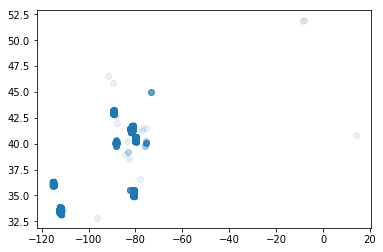

In [118]:
fig, ax = plt.subplots()
ax.scatter(final_df['longitude'],final_df['latitude'],alpha=.1)

In [121]:
final_df[final_df['longitude'] > -20]

,name,city,state,postal_code,address,business_id,latitude,longitude,neighborhood,restaurant_count,restaurant_count > 1,restaurant_count > 5,restaurant_count > 25,review_count,stars,Attribute|BusinessAcceptsCreditCards value:,Attribute|RestaurantsPriceRange2 value:,Attribute|RestaurantsTakeOut value:,Attribute|BusinessParking|garage value:,Attribute|BusinessParking|street value:,Attribute|BusinessParking|lot value:,Attribute|BusinessParking|valet value:,Attribute|BusinessParking|validated value:,Attribute|BikeParking value:,Attribute|OutdoorSeating value:,Attribute|RestaurantsGoodForGroups value:,Attribute|RestaurantsDelivery value:,Attribute|RestaurantsReservations value:,Attribute|GoodForKids value:,Attribute|HasTV value:,Attribute|Ambience|romantic value:,Attribute|Ambience|intimate value:,Attribute|Ambience|classy value:,Attribute|Ambience|hipster value:,Attribute|Ambience|touristy value:,Attribute|Ambience|trendy value:,Attribute|Ambience|upscale value:,Attribute|Ambience|casual value:,Attribute|Ambience|divey value:,Attribute|GoodForMeal|dessert value:,Attribute|GoodForMeal|latenight value:,Attribute|GoodForMeal|lunch value:,Attribute|GoodForMeal|dinner value:,Attribute|GoodForMeal|breakfast value:,Attribute|GoodForMeal|brunch value:,Attribute|Caters value:,Attribute|WheelchairAccessible value:,Attribute|HappyHour value:,Attribute|GoodForDancing value:,Attribute|DriveThru value:,Attribute|Music|dj value:,Attribute|Music|background_music value:,Attribute|Music|no_music value:,Attribute|Music|karaoke value:,Attribute|Music|live value:,Attribute|Music|video value:,Attribute|Music|jukebox value:,Attribute|CoatCheck value:,Attribute|DogsAllowed value:,Category|Restaurants_true,Category|Food_true,Category|Nightlife_true,Category|Bars_true,Category|Fast Food_true,Category|American (Traditional)_true,Category|Sandwiches_true,Category|Pizza_true,Category|Mexican_true,Category|Burgers_true,Category|American (New)_true,Category|Breakfast & Brunch_true,Category|Coffee & Tea_true,Category|Grocery_true,Category|Italian_true,Category|Specialty Food_true,Category|Shopping_true,Category|Chinese_true,Category|Event Planning & Services_true,Category|Chicken Wings_true,Category|Salad_true,Category|Bakeries_true,Category|Desserts_true,Category|Convenience Stores_true,Category|Ice Cream & Frozen Yogurt_true,Category|Sports Bars_true,Category|Seafood_true,Category|Beer_true,Category|Wine & Spirits_true,Category|Caterers_true,Category|Delis_true,Category|Cafes_true,Category|Drugstores_true,Category|Japanese_true,Category|Arts & Entertainment_true,Category|Juice Bars & Smoothies_true,Category|Pubs_true,Category|Steakhouses_true,Category|Sushi Bars_true,Category|Asian Fusion_true,Category|Barbeque_true,...,five-star: town,five-star: fantastic,2-4_star: long,five-star: didn,five-star: breakfast,2-4_star: beer,five-star: beer,2-4_star: vegas,five-star: table,2-4_star: breakfast,five-star: burger,one_star: place,2-4_star: food,2-4_star: place,five-star: food,2-4_star: tea,five-star: place,one_star: food,five-star: just,one_star: just,one_star: like,five-star: tea,2-4_star: like,five-star: ordered,one_star: business,one_star: good,2-4_star: service,one_star: tasted,five-star: time,one_star: tea,one_star: said,one_star: don,2-4_star: don,2-4_star: time,2-4_star: wasn,five-star: like,2-4_star: just,one_star: didn,five-star: service,one_star: really,2-4_star: order,2-4_star: good,one_star: going,one_star: time,five-star: don,one_star: came,2-4_star: ordered,one_star: service,2-4_star: bar,2-4_star: bad,five-star: better,2-4_star: try,five-star: good,five-star: order,one_star: bad,2-4_star: chicken,one_star: wasn,five-star: flavor,five-star: cheese,five-star: came,one_star: half,2-4_star: came,one_star: got,2-4_star: said,one_star: bar,one_star: went,one_star: ordered,five-star: going,five-star: try,one_star: manager,2-4_star: going,one_star: owner,one_star: order,2-4_star: cheese,one_star: location,2-4_star: pizza,five-star: vegas,2-4_star: really,one_st

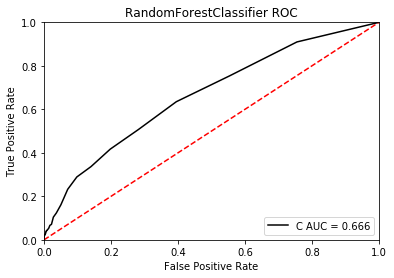

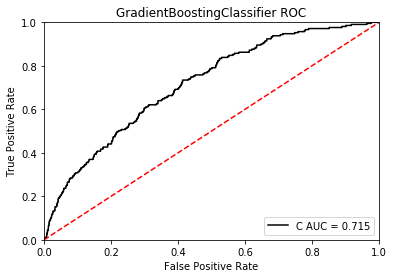

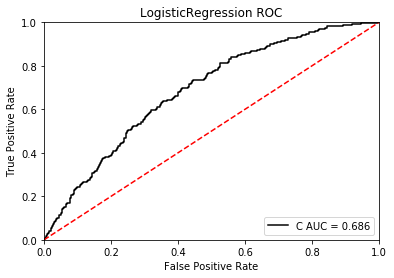

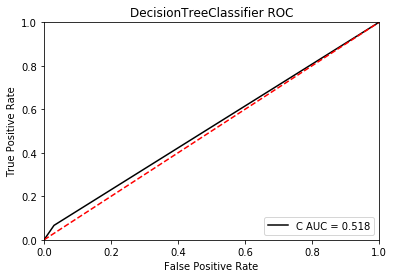

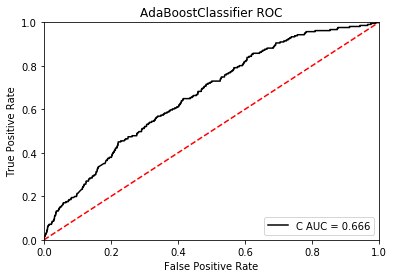

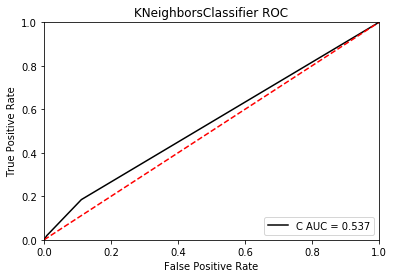

In [122]:
for model in models:
    plot_roc(model, X_test, y_test)

In [128]:
top_review_values, top_review_columns = gb_best_features(df, x_columns, len(x_columns))

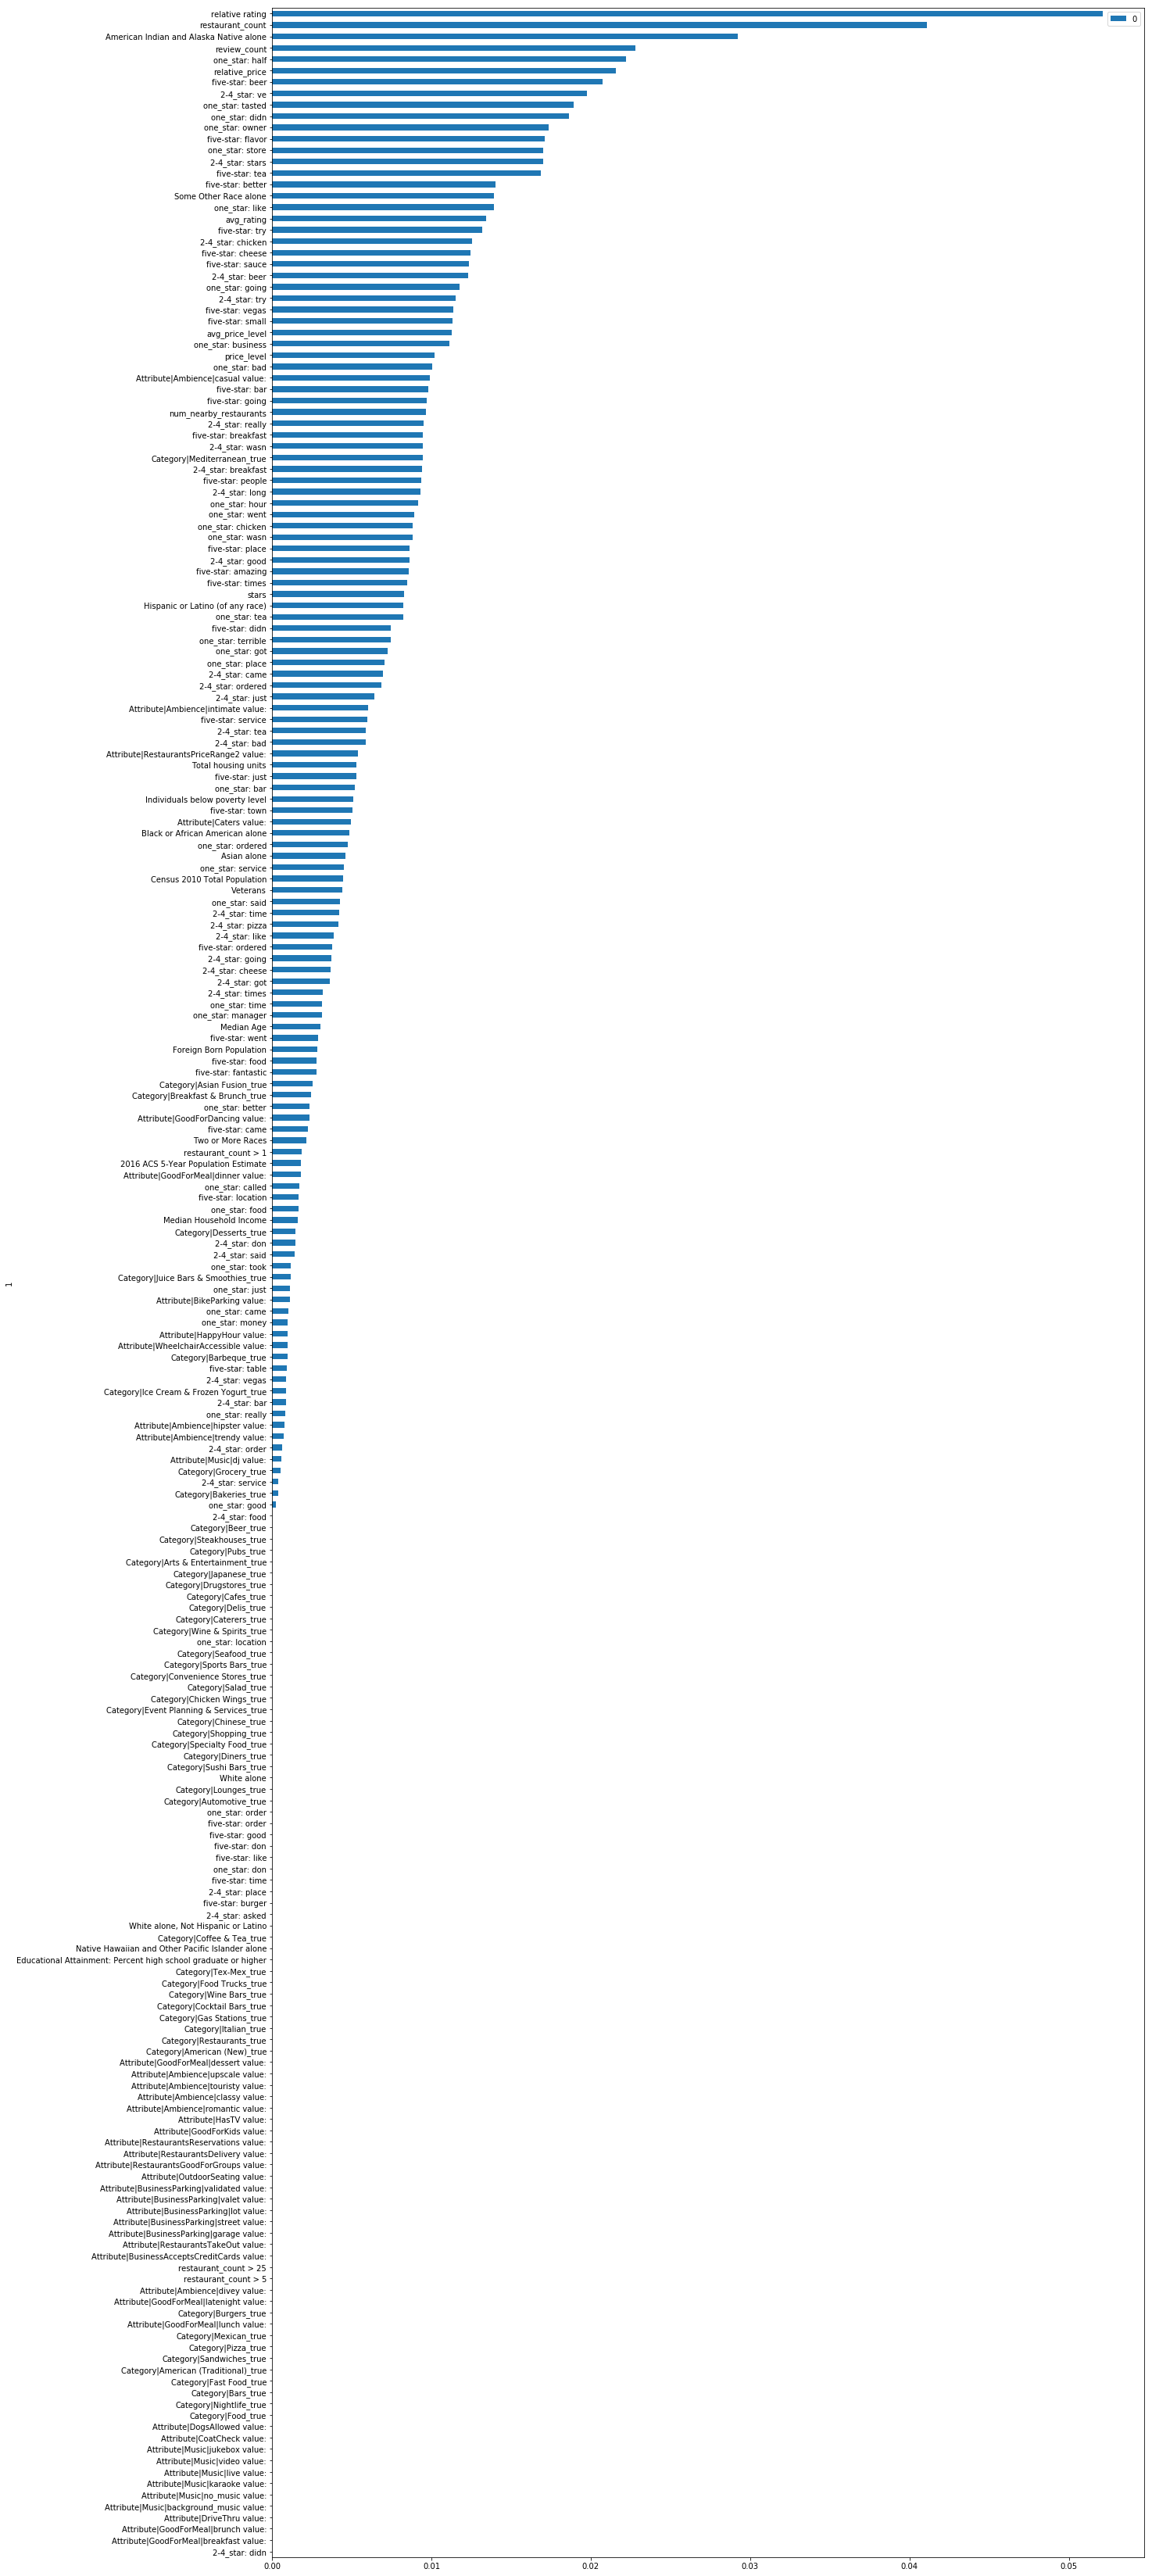

In [129]:
plot_best_features(top_review_values, top_review_columns,20,60)

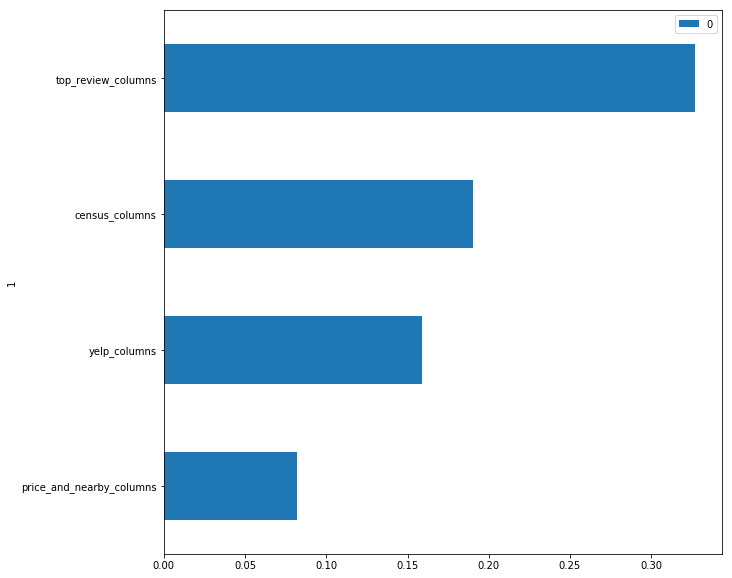

In [139]:
all_values, all_features = rf_best_features(df, x_columns, len(x_colums))

feature_dict = {'yelp_columns':yelp_columns, 'census_columns':census_columns, \
                'price_and_nearby_columns':price_and_nearby_columns,'top_review_columns':top_review_columns}
feature_category_values = {'yelp_columns':0, 'census_columns':0, \
                'price_and_nearby_columns':0,'top_review_columns':0}

feature_value_pairs = dict(list(zip(all_features, all_values)))

for key, values in feature_dict.items():
    for v in values:
        feature_category_values[key] += feature_value_pairs[v]

plot_best_features(list(feature_category_values.values()),list(feature_category_values.keys()), )